# BacterDetect

## Classificador de bacterias gram negativas e gram positivas

# Etapa 1: Importação das bibliotecas

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas.util.testing as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import zipfile
tf.__version__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


'2.2.0-rc3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/tensorflow/maskDetect.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

# Etapa 2: Transfer learning e reuso do modelo

In [4]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
base_model.summary()

In [0]:
x = base_model.output

In [0]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [0]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [0]:
model.summary()

In [0]:
for layer in model.layers[:175]:
  layer.trainable = False

In [0]:
for layer in model.layers[175:]:
  layer.trainable = True

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory('/content/maskDetect/train',
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)


Found 649 images belonging to 2 classes.


In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
 history = model.fit(train_generator,
                    epochs=7,steps_per_epoch=1)


Epoch 1/7
1/1 [==============================] - 0s 3ms/step - loss: 0.3736 - accuracy: 0.9375
Epoch 2/7
1/1 [==============================] - 0s 2ms/step - loss: 4.7938e-05 - accuracy: 1.0000
Epoch 3/7
1/1 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9688
Epoch 4/7
1/1 [==============================] - 0s 1ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 5/7
1/1 [==============================] - 0s 6ms/step - loss: 2.2352e-08 - accuracy: 1.0000
Epoch 6/7
1/1 [==============================] - 0s 8ms/step - loss: 2.2761e-06 - accuracy: 1.0000
Epoch 7/7
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000


# Etapa 3: Avaliação do modelo

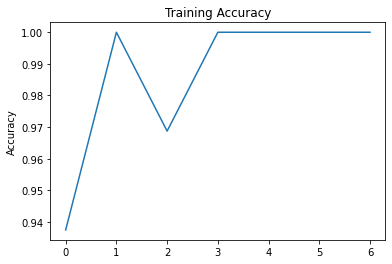

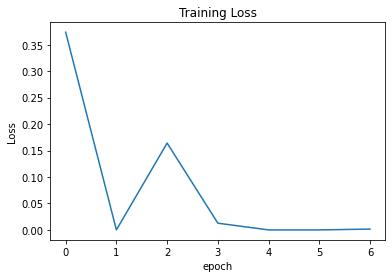

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

# Etapa 4: teste com imagem

In [0]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/ex-presidente-luiz-inacio-lula-da-silva-1585232017629_v2_450x450.jpg', target_size=(224,224))

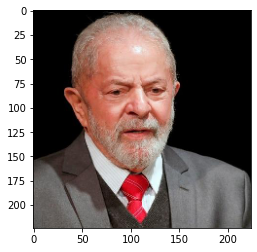

In [104]:
plt.imshow(sample_image)

In [105]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
np.shape(sample_image)

(224, 224, 3)

In [106]:
sample_image = np.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

(1, 224, 224, 3)

In [0]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [108]:
predictions = model.predict(sample_image)
print(predictions)

[[1.3914738e-09 1.0000000e+00]]


In [0]:
classes=['cidadão de bem protegido','vagabundo sem mascara']

In [110]:
classes[np.argmax(predictions[0])]

'vagabundo sem mascara'

# Etapa 5: Deploy do modelo

In [0]:
model_json = model.to_json()
with open("maskDetect.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
model.save_weights("maskDetect.h5")